In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_validate

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.dummy import DummyRegressor
from sklearn.neighbors import KNeighborsRegressor

## 1. Leitura dos Dados

In [2]:
df= pd.read_csv("../data/raw/data.csv")
df_dictionary = pd.read_csv('../data/external/dictionary.csv')

In [3]:
df_dictionary

,variavel,descricao,tipo,subtipo
0,carat,"Peso do diamante (0,2--5,01).",quantitativa,contínua
1,cut,"Qualidade do corte (Fair, Good, Very Good, Pre...",qualitativa,ordinal
2,color,"Cor de diamante, de D (melhor) a J (pior)",qualitativa,ordinal
3,clarity,"Clareza do diamante (I1 (pior), SI2 SI1, VS2, ...",qualitativa,ordinal
4,depth,Percentagem total de profundidade = z /média(x...,quantitativa,contínua
5,table,Largura do topo do diamante em relação ao pont...,quantitativa,contínua
6,price,"Preço em dólares dos EUA ($326-$18,823).",quantitativa,contínua
7,x,Comprimento em mm (0-10.74).,quantitativa,contínua
8,y,Largura em mm (0-58.9).,quantitativa,contínua
9,z,"Profundidade em mm (0-31,8).",quantitativa,contínua


In [4]:
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


#### Renomeando as Colunas

In [5]:
mapeamento_colunas = {
    'carat': 'peso',
    'cut': 'corte',
    'color': 'cor',
    'clarity': 'claridade',
    'depth': 'profundidade',
    'table': 'tabela',
    'price': 'preco',
}

In [6]:
def renomear_colunas(df, mapping):
    df.rename(columns=mapping, inplace=True)
    return df

In [7]:
df_dictionary['variavel'] = df_dictionary['variavel'].replace(mapeamento_colunas)
df = renomear_colunas(df, mapeamento_colunas)

In [8]:
#aplicando a escala logarítmica para reduzir a dispersão dos dados para uma melhor análise
df['preco'] = np.log1p(df['preco'])

## 2. Pré-Processamento dos Dados

#### Definição das Variáveis do Modelo de Previsão

In [9]:
#ordenação dos dados por variável
cut_order = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
color_order = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
clarity_order = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

In [10]:
target_variable = 'preco'

ordinal_variables = (
    df_dictionary
    .query("subtipo == 'ordinal' and variavel != @target_variable")
    .variavel
    .to_list()
)
continuous_variables = (
    df_dictionary
    .query("subtipo == 'contínua' and variavel != @target_variable")
    .variavel
    .to_list()
)

X = df.drop(columns=[target_variable])
y = df[target_variable]

#### Imputação e Codificação

In [11]:
ordinal_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='most_frequent')), # tratamento para dados faltantes
     ("encoding", OrdinalEncoder(categories=[cut_order, color_order, clarity_order], 
                                 handle_unknown='use_encoded_value', unknown_value=-1)) # codificando categorias de acordo com a ordem
])

continuous_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy='mean')), # tratamento para dados faltantes
    ("normalization", StandardScaler()), # normalização de dados
])

In [12]:
preprocessor = ColumnTransformer([
    ("ordinal", ordinal_preprocessor, ordinal_variables), 
    ("continuous", continuous_preprocessor, continuous_variables), 
])

In [13]:
preprocessor

ColumnTransformer(transformers=[('ordinal',
                                 Pipeline(steps=[('missing',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoding',
                                                  OrdinalEncoder(categories=[['Fair',
                                                                              'Good',
                                                                              'Very '
                                                                              'Good',
                                                                              'Premium',
                                                                              'Ideal'],
                                                                             ['D',
                                                                              'E',
                                                                              'F',
                                                                              'G',
                                                                              'H',
                                                                              'I',
                                                                              'J'],
                                                                             ['I1',
                                                                              'SI2',
                                                                              'SI1',
                                                                              'VS2',
                                                                              'VS1',
                                                                              'VVS2',
                                                                              'VVS1',
                                                                              'IF']],
                                                                 handle_unknown='use_encoded_value',
                                                                 unknown_value=-1))]),
                                 ['corte', 'cor', 'claridade']),
                                ('continuous',
                                 Pipeline(steps=[('missing', SimpleImputer()),
                                                 ('normalization',
                                                  StandardScaler())]),
                                 ['peso', 'profundidade', 'tabela', 'x', 'y',
                                  'z'])])

## 3. Avaliação e Comparação de Modelos

#### Validação Cruzada e Métricas de Desempenho

In [14]:
modelos = [DummyRegressor(strategy="mean"), LinearRegression(), KNeighborsRegressor(n_neighbors=5), RandomForestRegressor(n_estimators=100, random_state=42)]

In [15]:
metricas = [
    'neg_mean_absolute_error',
    'neg_mean_squared_error',
    'neg_mean_absolute_percentage_error',
    'r2',
]

monte_carlo = ShuffleSplit(n_splits=10, test_size=.2, random_state=42)

In [16]:
results_total = None
for modelo in modelos:
    model_name = modelo.__class__.__name__
    print(f"Rodando para o modelo: {model_name}")
    approach = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('modelo', modelo),
    ])

    scores = cross_validate(
        approach, X, y,
        scoring=metricas, 
        cv=monte_carlo
    )
    results_model = pd.DataFrame(scores)
    results_model['Modelo'] = model_name
    if results_total is None:
        results_total = results_model
    else:
        results_total = pd.concat([results_total, results_model])

Rodando para o modelo: DummyRegressor
Rodando para o modelo: LinearRegression
Rodando para o modelo: KNeighborsRegressor
Rodando para o modelo: RandomForestRegressor


#### Resultado e Comparação

In [17]:
# Renomear colunas
results_total = results_total.rename(
    columns={
        "fit_time": "Tempo de Treinamento",
        "score_time": "Tempo de Avaliação",
        "test_neg_mean_absolute_error": "Erro Absoluto Médio (Negativo)",
        "test_neg_mean_squared_error": "Erro Quadrático Médio (Negativo)",
        "test_neg_mean_absolute_percentage_error": "Erro Percentual Médio (Negativo)",
        "test_r2": "Coeficiente de Determinação (R²)",
        "Modelo": "Modelo"
    }
)

In [18]:
results_total.groupby('Modelo').agg(['mean', 'std']).T

Modelo                                 DummyRegressor  KNeighborsRegressor  \
Tempo de Treinamento             mean        0.049933             0.143699   
                                 std         0.002979             0.026041   
Tempo de Avaliação               mean        0.009215             0.562236   
                                 std         0.008056             0.109917   
Erro Absoluto Médio (Negativo)   mean       -0.874395            -0.103260   
                                 std         0.003155             0.000764   
Erro Quadrático Médio (Negativo) mean       -1.026167            -0.019330   
                                 std         0.007380             0.000400   
Erro Percentual Médio (Negativo) mean       -0.114703            -0.013661   
                                 std         0.000456             0.000105   
Coeficiente de Determinação (R²) mean       -0.000036             0.981161   
                                 std         0.000042             0.000427   

Modelo                                 LinearRegression  RandomForestRegressor  
Tempo de Treinamento             mean          0.082842              18.002205  
                                 std           0.029966               1.434094  
Tempo de Avaliação               mean          0.013418               0.317732  
                                 std           0.007249               0.041841  
Erro Absoluto Médio (Negativo)   mean         -0.121151              -0.062866  
                                 std           0.000557               0.000631  
Erro Quadrático Médio (Negativo) mean         -0.034030              -0.008153  
                                 std           0.005183               0.000288  
Erro Percentual Médio (Negativo) mean         -0.015654              -0.008099  
                                 std           0.000083               0.000080  
Coeficiente de Determinação (R²) mean          0.966822               0.992053  
                                 std           0.005171               0.000316

In [19]:
resultado_agregado = results_total.groupby('Modelo').agg(['mean', 'std']).T
resultado_agregado.columns

Index(['DummyRegressor', 'KNeighborsRegressor', 'LinearRegression',
       'RandomForestRegressor'],
      dtype='object', name='Modelo')

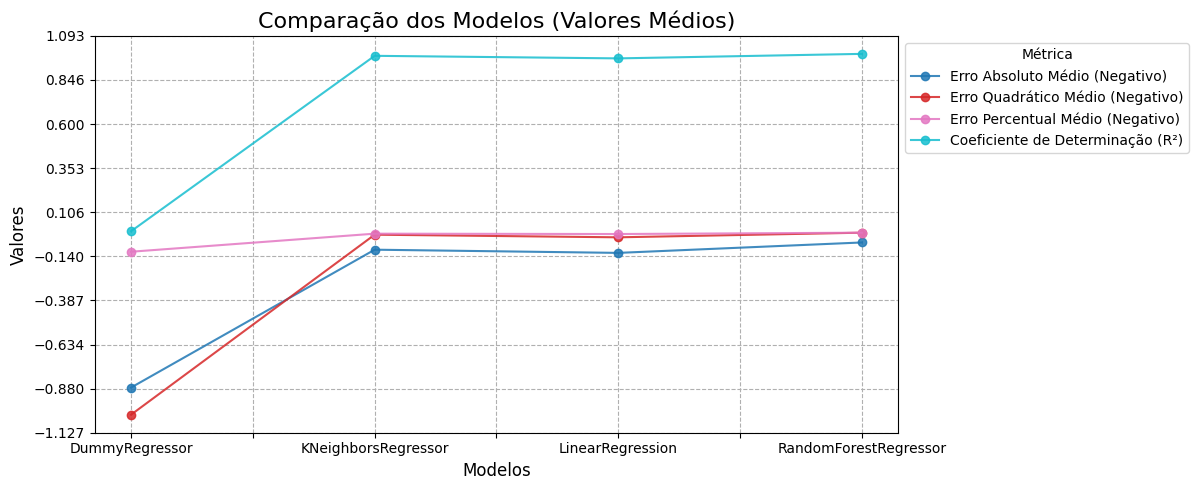

In [20]:
resultado_agregado_mean = resultado_agregado.xs('mean', level=1, axis=0).drop(index=['Tempo de Treinamento', 'Tempo de Avaliação'])

fig, ax = plt.subplots(figsize=(12, 5))
resultado_agregado_mean.T.plot(kind='line', marker='o', ax=ax, cmap='tab10', alpha=0.85)

ax.set_title("Comparação dos Modelos (Valores Médios)", fontsize=16)
ax.set_ylabel("Valores", fontsize=12)
ax.set_xlabel("Modelos", fontsize=12)
ax.legend(title="Métrica", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=1)
plt.tight_layout()

y_min, y_max = ax.get_ylim()
ax.set_yticks(np.linspace(y_min, y_max, num=10))

plt.show()

* O **RandomForestRegressor** teve um melhor desempenho, com:
   - **Erro Absoluto Médio**: -0.0629
   - **Erro Quadrático Médio**: -0.0082
   - **Erro Percentual Médio**: -0.0081
   - **Coeficiente de Determinação (R²)**: 0.9921
* O **KNeighborsRegressor** teve um bom desempenho no geral, com um R² de 0.9812 e erros baixos, mas não superou o **RandomForestRegressor**.
* O **LinearRegression** ficou em terceiro lugar em precisão, com um R² de 0.9668 e erros um pouco maiores.
* O **DummyRegressor** serviu como baseline, apresentando os maiores erros e o menor R² (-0.00004), confirmando sua limitação.

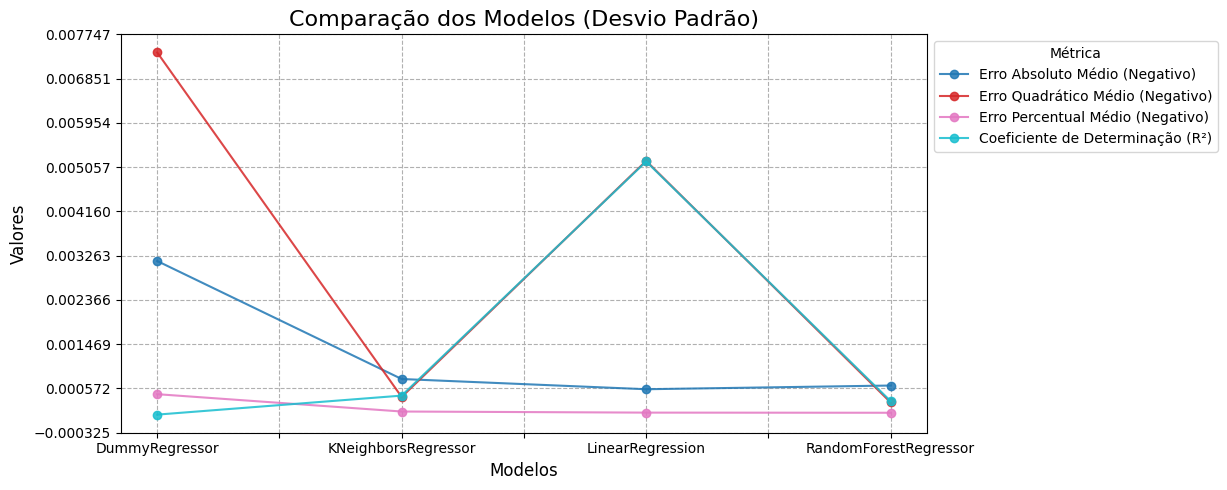

In [21]:
resultado_agregado_std = resultado_agregado.xs('std', level=1, axis=0).drop(index=['Tempo de Treinamento', 'Tempo de Avaliação'])

fig, ax = plt.subplots(figsize=(12, 5))
resultado_agregado_std.T.plot(kind='line', marker='o', ax=ax, cmap='tab10', alpha=0.85)

ax.set_title("Comparação dos Modelos (Desvio Padrão)", fontsize=16)
ax.set_ylabel("Valores", fontsize=12)
ax.set_xlabel("Modelos", fontsize=12)
ax.legend(title="Métrica", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=1)
plt.tight_layout()

y_min, y_max = ax.get_ylim()
ax.set_yticks(np.linspace(y_min, y_max, num=10))

plt.show()

* O **RandomForestRegressor** teve um melhor desempenho, com os menores desvios padrões:
   - **Erro Absoluto Médio**: 0.0032
   - **Erro Quadrático Médio**: 0.0003
   - **Erro Percentual Médio**: 0.0001
   - **Coeficiente de Determinação (R²)**: 0.0003
* O **DummyRegressor**, em contrapartida, teve os maiores desvios padrões. 
* O **KNeighborsRegressor** e o **LinearRegression** apresentaram um desvio intermediários, mostrando maior estabilidade que o baseline.

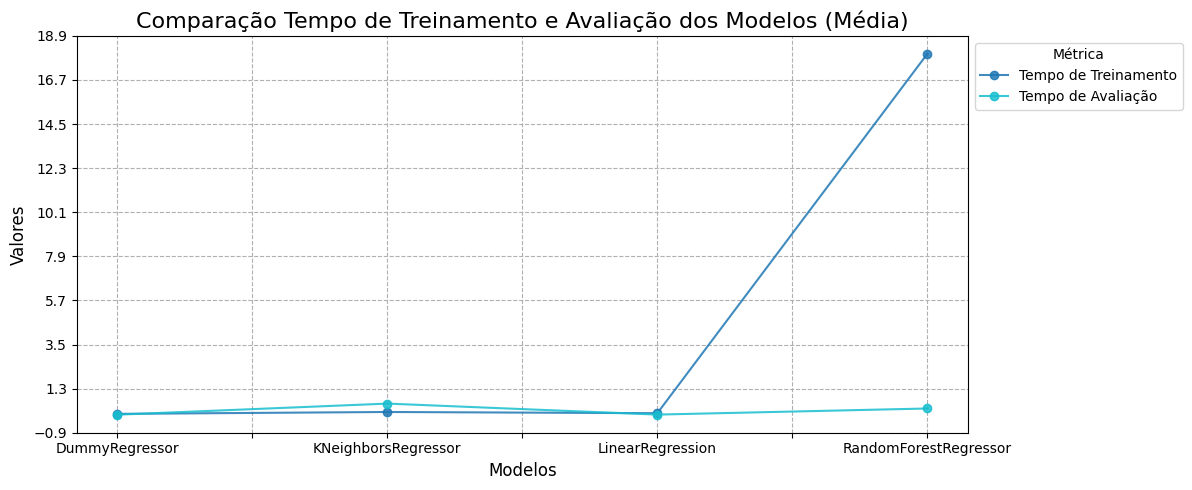

In [22]:
resultado_tempo_mean = resultado_agregado.xs('mean', level=1, axis=0).loc[['Tempo de Treinamento', 'Tempo de Avaliação']]

fig, ax = plt.subplots(figsize=(12, 5))
resultado_tempo_mean.T.plot(kind='line', marker='o', ax=ax, cmap='tab10', alpha=0.85)

ax.set_title("Comparação Tempo de Treinamento e Avaliação dos Modelos (Média)", fontsize=16)
ax.set_ylabel("Valores", fontsize=12)
ax.set_xlabel("Modelos", fontsize=12)
ax.legend(title="Métrica", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=1)
plt.tight_layout()

y_min, y_max = ax.get_ylim()
ax.set_yticks(np.linspace(y_min, y_max, num=10))

plt.show()

* O **DummyRegressor** foi o mais rápido, com:
    - **Tempo de Treinamento** médio de 0.0499 segundos.
    - **Tempo de Avaliação** médio de 0.0092 segundos.
* O **RandomForestRegressor** foi o mais lento:
    - **Tempo de Treinamento** médio de 18.0022 segundos, refletindo sua complexidade.
    - **Tempo de Avaliação** médio de 0.3177 segundos.
* O **KNeighborsRegressor** teve o maior **Tempo de Avaliação** (0.5622 segundos).

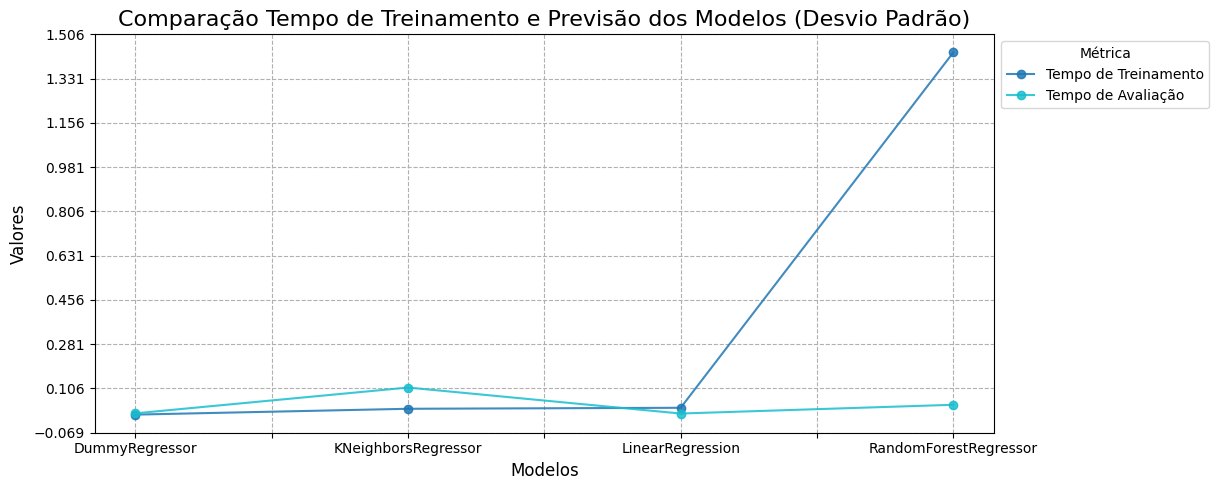

In [23]:
resultado_tempo_std = resultado_agregado.xs('std', level=1, axis=0).loc[['Tempo de Treinamento', 'Tempo de Avaliação']]

fig, ax = plt.subplots(figsize=(12, 5))
resultado_tempo_std.T.plot(kind='line', marker='o', ax=ax, cmap='tab10', alpha=0.85)

ax.set_title("Comparação Tempo de Treinamento e Previsão dos Modelos (Desvio Padrão)", fontsize=16)
ax.set_ylabel("Valores", fontsize=12)
ax.set_xlabel("Modelos", fontsize=12)
ax.legend(title="Métrica", bbox_to_anchor=(1, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=1)
plt.tight_layout()

y_min, y_max = ax.get_ylim()
ax.set_yticks(np.linspace(y_min, y_max, num=10))

plt.show()

* O **RandomForestRegressor** teve o maior **Tempo de Treinamento** (18.0022 segundos), refletindo a sua complexidade.
* O **KNeighborsRegressor** teve um maior desvio no **Tempo de Avaliação** (0.1099 segundos), indicando menor previsibilidade em comparação com outros modelos.
* Modelos mais simples, como o **DummyRegressor**, tiveram baixos desvios.

## 4. Conclusão da Análise

O **RandomForestRegressor** é o modelo que oferece o melhor desempenho preditivo, com os menores erros absolutos, quadráticos e percentuais, além do maior coeficiente de determinação (R² = 0.9921), mostrando que é altamente confiável e consistente em diferentes execuções. Ele é a escolha ideal para cenários onde a precisão e a estabilidade das previsões são prioridades.


Por outro lado, sua principal limitação é o tempo de treinamento elevado (em média 18.0022 segundos), o que pode torná-lo menos prático para aplicações que exigem atualizações rápidas ou eficiência computacional.


Nesse caso, o **LinearRegression** surge como uma excelente alternativa. Apesar de ter um desempenho levemente inferior (R² = 0.9668), ele compensa com tempos muito mais curtos de treinamento e avaliação, sendo ideal para cenários onde rapidez e simplicidade são essenciais.